Here we try to conduct feature inference attacks on model predictions in split learning

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
# limit tf to use the first gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


2022-03-29 21:10:18.165685: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-29 21:10:18.875904: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10545 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [3]:
def make_dataset(x, y, f):
    x = tf.data.Dataset.from_tensor_slices(x).map(f)
    y = tf.data.Dataset.from_tensor_slices(y)
    return tf.data.Dataset.zip((x, y)).shuffle(1000)

def load_mnist():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    
    def resize_clip(x):
        x = x[:,:,None]
        x = tf.tile(x, (1,1,3))
        x = tf.image.resize(x, (32, 32))
        x = x/(255.0/2.0)-1.0
        x = tf.clip_by_value(x, -1., 1.)
        return x
    
    target_ds = make_dataset(x_train, y_train, resize_clip)
    aux_ds = make_dataset(x_test, y_test, resize_clip)

    return target_ds, aux_ds

In [4]:
target_ds, aux_ds = load_mnist()

In [5]:
def ResBlock(inputs, dim, ks=3, bn=False, activation='relu', stride=1):
    x = inputs
    if bn:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Conv2D(dim, ks, stride, padding='same')(x)
    if bn:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Conv2D(dim, ks, padding='same')(x)
    if stride > 1:
        inputs = tf.keras.layers.Conv2D(dim, ks, stride, padding='same')(inputs)
    return inputs + x

def make_f(input_shape, level):
    xin = tf.keras.layers.Input(input_shape)
    
    x = tf.keras.layers.Conv2D(64, 3, 1, padding='same')(xin)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(2)(x)    
    x = ResBlock(x, 64)
    
    if level == 1:
        return tf.keras.Model(xin, x)
    x = ResBlock(x, 128, stride=2)
    if level == 2:
        return tf.keras.Model(xin, x)
    x = ResBlock(x, 128)
    if level == 3:
        return tf.keras.Model(xin, x)
    x = ResBlock(x, 256, stride=2)
    if level <= 4:
        return tf.keras.Model(xin, x)    
    else:
        raise Exception('No level %d' % level)

def make_g(input_shape, level, units, act):
    xin = tf.keras.layers.Input(input_shape)
    x = xin
    if level == 1:
        x = ResBlock(x, 128, stride=2)
    if level <= 2:
        x = ResBlock(x, 128)
    if level <= 3:
        x = ResBlock(x, 256, stride=2)

    x = ResBlock(x, 256)
    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(units, activation=act)(x)
    return tf.keras.Model(xin, x)

"""
Note that the attacker does not know the model architecture of the client,
but only knows the output dimension of the client model.
"""
def make_e(input_shape, level, act):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation=act)(xin)
    if level == 1:
        x = tf.keras.layers.Conv2D(64, 3, 1, padding='same')(x)
        return tf.keras.Model(xin, x)
    x = tf.keras.layers.Conv2D(128, 3, 2, padding='same', activation=act)(x)
    if level <= 3:
        x = tf.keras.layers.Conv2D(128, 3, 1, padding='same')(x)
        return tf.keras.Model(xin, x)
    x = tf.keras.layers.Conv2D(256, 3, 2, padding='same', activation=act)(x)
    if level <= 4:
        x = tf.keras.layers.Conv2D(256, 3, 1, padding='same')(x)
        return tf.keras.Model(xin, x)
    else:
        raise Exception('No level %d' % level)

"""
This critic/discriminator architecture follows the one from FSHA.
"""
def make_c(input_shape, level):
    xin = tf.keras.layers.Input(input_shape)
    if level == 1:
        x = tf.keras.layers.Conv2D(128, 3, 2, padding='same', activation='relu')(xin)
        x = tf.keras.layers.Conv2D(256, 3, 2, padding='same')(x)
    if level <= 3:
        x = tf.keras.layers.Conv2D(256, 3, 2, padding='same')(xin)
    if level <= 4:
        x = tf.keras.layers.Conv2D(256, 3, 1, padding='same')(xin)
    bn = False
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = ResBlock(x, 256, bn=bn)
    x = tf.keras.layers.Conv2D(256, 3, 2, padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(xin, x)

def make_d_fsha(input_shape, level, act, channels=3):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Conv2DTranspose(256, 3, 2, padding='same', activation=act)(xin)
    if level == 1:
        x = tf.keras.layers.Conv2D(channels, 3, 1, padding='same', activation="tanh")(x)
        return tf.keras.Model(xin, x)
    x = tf.keras.layers.Conv2DTranspose(128, 3, 2, padding='same', activation=act)(x)
    if level <= 3:
        x = tf.keras.layers.Conv2D(channels, 3, 1, padding='same', activation="tanh")(x)
        return tf.keras.Model(xin, x)
    x = tf.keras.layers.Conv2DTranspose(channels, 3, 2, padding='same', activation="tanh")(x)
    return tf.keras.Model(xin, x)

In [6]:
split = 4
f = make_f(input_shape=target_ds.element_spec[0].shape, level=split)
g = make_g(input_shape=f.layers[-1].output_shape[1:], level=split, units=10, act="softmax")

In [11]:
train_batches = target_ds.batch(64, drop_remainder=True).repeat(-1).take(10000)
f_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
i=1
loss_sum = 0.0
acc_sum = 0.0
for (x, y) in train_batches:
    with tf.GradientTape(persistent=True) as tape:
        z = f(x, training=True)
        y_pred = g(z, training=True)
        loss = tf.keras.losses.SparseCategoricalCrossentropy()(y_true=y, y_pred=y_pred)

    var = f.trainable_variables + g.trainable_variables
    gradients = tape.gradient(loss, var)
    f_opt.apply_gradients(zip(gradients, var))
    acc = tf.keras.metrics.SparseCategoricalAccuracy()(y_true=y, y_pred=y_pred)
    loss_sum += loss
    acc_sum += acc
    if i % 500 == 0:
        print("Iteration {}: training loss {}, accuracy: {}".format(i, loss_sum/500, acc_sum/500))
        loss_sum = 0.0
        acc_sum = 0.0
    i += 1

Iteration 500: training loss 0.06838104873895645, accuracy: 0.9839375019073486
Iteration 1000: training loss 0.062108349055051804, accuracy: 0.9837812781333923
Iteration 1500: training loss 0.0393635556101799, accuracy: 0.9885937571525574
Iteration 2000: training loss 0.04572893679141998, accuracy: 0.9879375100135803
Iteration 2500: training loss 0.047429438680410385, accuracy: 0.9895625114440918
Iteration 3000: training loss 0.11218278110027313, accuracy: 0.9815937280654907
Iteration 3500: training loss 0.030831865966320038, accuracy: 0.991531252861023
Iteration 4000: training loss 0.02210172824561596, accuracy: 0.9938750267028809
Iteration 4500: training loss 0.02077530510723591, accuracy: 0.9936562776565552
Iteration 5000: training loss 0.020860599353909492, accuracy: 0.9940937757492065
Iteration 5500: training loss 0.02077043429017067, accuracy: 0.9938437342643738
Iteration 6000: training loss 0.03440152481198311, accuracy: 0.9909062385559082
Iteration 6500: training loss 0.1046119

In [19]:
def get_gradient_penalty(x, x_gen):
    e_shape = [1 for i in range(len(x.shape))]
    e_shape[0] = x.shape[0]
    epsilon = tf.random.uniform(e_shape, 0.0, 1.0)
    x_hat = epsilon * x + (1 - epsilon) * x_gen
    with tf.GradientTape() as t:
        t.watch(x_hat)
        d_hat = c(x_hat, training=True)
    gradients = t.gradient(d_hat, x_hat)
    ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[i + 1 for i in range(len(x.shape)-2)]))
    d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
    return d_regularizer

In [24]:
"""
Note that this is a generator only for 32x32x3 images
"""
def make_d(input_shape, channels=3):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(8*8*256, use_bias=False, input_shape=input_shape))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(channels, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

In [25]:
import math
inference_batches = target_ds.batch(64, drop_remainder=True).repeat(-1).take(10000)
aux_batches = aux_ds.batch(64, drop_remainder=True).repeat(-1).take(10000)
iterator = zip(inference_batches, aux_batches)

e_opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
d_opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
c_opt = tf.keras.optimizers.Adam(learning_rate=0.00001)

# e = make_e(input_shape=target_ds.element_spec[0].shape, level=split, act=None)
e = make_f(input_shape=target_ds.element_spec[0].shape, level=split)
# d = make_d_fsha(input_shape=f.layers[-1].output_shape[1:], level=split, act=None)
flat_inter_dim = math.prod(f.layers[-1].output_shape[1:])
d = make_d(input_shape=(flat_inter_dim, ))
c = make_c(input_shape=f.layers[-1].output_shape[1:], level=split)

i = 1
mse_sum=0.0
for (x, _), (xp, _) in iterator:
    with tf.GradientTape(persistent=True) as tape:
        z = f(x, training=False)
        zp = e(xp, training=True)
        
        c_privite_logits = c(z, training=True)
        c_public_logits = c(zp, training=True)
                
        e_loss = -tf.reduce_mean(c_public_logits)
        c_loss = tf.reduce_mean( c_public_logits ) - tf.reduce_mean( c_privite_logits )
        gp = get_gradient_penalty(z, zp)
        c_loss += gp * float(500)

        x_temp = d(zp.numpy().reshape((64, flat_inter_dim)), training=True)
        d_loss = tf.losses.MeanSquaredError()(xp, x_temp)

    # encoder is updated by e_loss, to simulate
    var = e.trainable_variables
    gradients = tape.gradient(e_loss, var)
    e_opt.apply_gradients(zip(gradients, var))

    # update critic (discriminator) c:
    var = c.trainable_variables
    gradients = tape.gradient(c_loss, var)
    c_opt.apply_gradients(zip(gradients, var))

    # update decoder d:
    var = d.trainable_variables
    gradients=tape.gradient(d_loss, var)
    d_opt.apply_gradients(zip(gradients, var))

    rec = d(z.numpy().reshape((64, flat_inter_dim)), training=False)
    loss_verif = tf.losses.MeanSquaredError()(x, rec)

    loss_sum += loss_verif
    if i % 500 == 0:
        print("Iteration {}: reconstruction mse: {}".format(i, loss_sum/500))
        loss_sum = 0.0
    
    i += 1

Iteration 500: reconstruction mse: 1.582827091217041
Iteration 1000: reconstruction mse: 0.6252844333648682
Iteration 1500: reconstruction mse: 0.6122902035713196
Iteration 2000: reconstruction mse: 0.5806804299354553
Iteration 2500: reconstruction mse: 0.5733239650726318
Iteration 3000: reconstruction mse: 0.5682569146156311
Iteration 3500: reconstruction mse: 0.5714158415794373
Iteration 4000: reconstruction mse: 0.5695286989212036
Iteration 4500: reconstruction mse: 0.5679804086685181
Iteration 5000: reconstruction mse: 0.5751163363456726
Iteration 5500: reconstruction mse: 0.567152738571167
Iteration 6000: reconstruction mse: 0.5410674214363098
Iteration 6500: reconstruction mse: 0.48113590478897095
Iteration 7000: reconstruction mse: 0.4464575946331024
Iteration 7500: reconstruction mse: 0.4341471493244171
Iteration 8000: reconstruction mse: 0.4394798278808594
Iteration 8500: reconstruction mse: 0.4376395046710968
Iteration 9000: reconstruction mse: 0.44058531522750854
Iteration 9

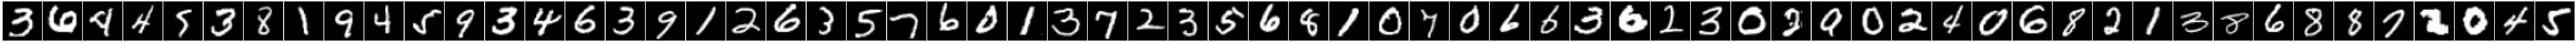

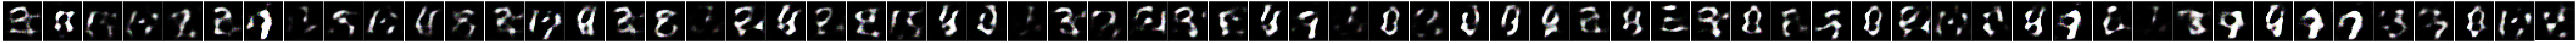

In [28]:
# imgs = np.array([x[0].numpy() for x in target_ds.take(20)])

def plot(X):
    n = len(X)
    X = (X+1)/2
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i].imshow((X[i]), cmap='inferno')
        ax[i].set(xticks=[], yticks=[])
        ax[i].set_aspect('equal')
    return fig

# fig = plot(imgs)

fig = plot(x)
fig = plot(rec)

# for split in [4]:
# #     flattened_z = mnist_dsa["mnist-split="+str(split)].f(imgs, training=False).numpy().reshape((len(imgs), mnist_dsa["mnist-split="+str(split)].flattened_inter_dim))
#     mse, rec_res = mnist_dsa["mnist-split="+str(split)].attack_examples(imgs)
#     fig = plot(rec_res)
#     print(mse)

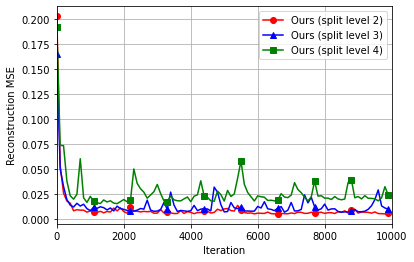

In [72]:
with open('log/mnist-all.pkl', 'rb') as f:
    log = pickle.load(f)

from matplotlib.pyplot import figure
# figure(figsize=(6.4,4.8))
log_freq = 100
# plt.yscale('logit')
plt.xlim([0,10000])
# plt.ylim([0.00, 0.20])
plt.grid()
sampled_log_2 = [sum(log["mnist-split=2"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["mnist-split=2"][:,0])/log_freq))]
sampled_log_3 = [sum(log["mnist-split=3"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["mnist-split=3"][:,0])/log_freq))]
sampled_log_4 = [sum(log["mnist-split=4"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["mnist-split=4"][:,0])/log_freq))]
ran = [i * log_freq for i in range(int(10000/log_freq))]
plt.plot(ran, sampled_log_2, 'ro-', ran, sampled_log_3, 'b^-', ran, sampled_log_4, 'gs-', markevery=11)
plt.ylabel('Reconstruction MSE')
plt.xlabel('Iteration')
plt.legend(["Ours (split level 2)", "Ours (split level 3)", "Ours (split level 4)"])
plt.savefig("fig/mnist-all.pdf", bbox_inches='tight')